## Analyze A/B Test Results

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, you will be working to understand the results of an A/B test run by an e-commerce website.  Your goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

**As you work through this notebook, follow along in the classroom and answer the corresponding quiz questions associated with each question.** The labels for each classroom concept are provided for each question.  This will assure you are on the right track as you work through the project, and you can feel more confident in your final submission meeting the criteria.  As a final check, assure you meet all the criteria on the [RUBRIC](https://review.udacity.com/#!/projects/37e27304-ad47-4eb0-a1ab-8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

In [2]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


the number of rows in the dataset

In [3]:
df.shape[0]

294478

the number of unique users in the dataset

In [4]:
df.user_id.nunique()

290584

the proportion of users converted

In [5]:
df.converted.mean()

0.11965919355605512

the number of times the `new_page` and `treatment` don't line up.

In [6]:
# id the group options
df.group.unique()

array(['control', 'treatment'], dtype=object)

In [7]:
# id the landing page options
df.landing_page.unique()

array(['old_page', 'new_page'], dtype=object)

In [8]:
# create the subset of mismatches for new_page and treatment
# I consulted resource #1 
mismatch = df[((df.group == 'treatment') & (df.landing_page != 'new_page')) | ((df.group == 'control') & (df.landing_page != 'old_page'))]
mismatch.shape[0]

3893

f. Do any of the rows have missing values?

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


**<span style="color:red">No missing values!</span>**

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [10]:
# I consulted resource #2
df2 = pd.concat([df, mismatch]).drop_duplicates(keep=False)

In [11]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [12]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [13]:
# I consulted the linked resource: 
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.duplicated.html
df2[df2.user_id.duplicated() == True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [14]:
df2[df2.user_id == 773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [15]:
df2 = df2.drop(index=2893)

In [16]:
# check duplicates were removed
df2[df2.duplicated()].shape[0]

0

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [17]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [18]:
p_control_converted = df2.query('group == "control"').converted.mean()
p_control_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [19]:
p_treament_converted = df2.query('group == "treatment"').converted.mean()
p_treament_converted

0.11880806551510564

In [20]:
# store the difference for use in calculating the p-value later
actual_obs_diff = p_treament_converted - p_control_converted
actual_obs_diff

-0.0015782389853555567

d. What is the probability that an individual received the new page?

In [21]:
df2.query('landing_page == "new_page"').shape[0]/df2.landing_page.shape[0]

0.5000619442226688

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**We need to rule out the possibility that the difference in conversion rates is not due to the randomness in the assignment of users to the control and treatment groups.
Additionally, the difference in conversion rates for the control and treatment groups is miniscule, so we do not yet have sufficient evidence to say the new page leads to more conversions.** 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$$H_{0}: p_{new} \leq p_{old}$$
$$H_{1}: p_{new} > p_{old}$$

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [22]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [23]:
# we assume that p_new and p_old are equal under the null
p_old = p_new
p_old

0.11959708724499628

In [24]:
# create p_null
p_null = p_new
p_null

0.11959708724499628

c. What is $n_{new}$?

In [25]:
n_new = df2.query('landing_page == "new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [26]:
n_old = df2.query('landing_page == "old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [27]:
new_page_converted = np.random.binomial(1, p_null, n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [28]:
old_page_converted =  np.random.binomial(1, p_null, n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [29]:
obs_diff = new_page_converted.mean()-old_page_converted.mean()
obs_diff

0.0015672183984062893

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [30]:
p_diffs = np.random.binomial(n_new, p_null, 10000)/n_new - np.random.binomial(n_old, p_null, 10000)/n_old

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

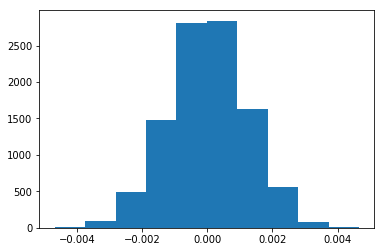

In [31]:
plt.hist(p_diffs);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [32]:
(p_diffs > actual_obs_diff).mean()

0.9088

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages? 

**We just computed the probability of observing our acutal observed difference, or one more extreme in favor of the alternative hypothesis, if the null hypothesis is true. In scientific studies, this is called a p-value. Since we are using a Type I Error threshold of 5%, or 0.05, and since or p-value is 0.899, we fail to reject the null hypothesis, that the conversion rate for the new landing page is less than or equal to the coversion rate for the old landing page.** 

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [33]:
import statsmodels.api as sm

convert_old = df2.query("landing_page == 'old_page' and converted == 1").shape[0]
convert_new = df2.query("landing_page == 'new_page' and converted == 1").shape[0]
n_old = df2.query('landing_page == "old_page"').shape[0]
n_new = df2.query("landing_page == 'new_page'").shape[0]

m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [34]:
# I consulted resource #3 
z_score, p_value = sm.stats.proportions_ztest([convert_new, convert_old], [n_new, n_old,] , alternative='larger')
z_score, p_value

(-1.3109241984234394, 0.9050583127590245)

In [35]:
# find the critical value for our one-sided z-test
from scipy.stats import norm
norm.ppf(1-0.05)

1.6448536269514722

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Since the z-score is less than the critical value, we again fail to reject the null hypothesis. The p-value we calculated with the new method leaves our decision unchanged since it is also above our Type I Error rate threshold of 0.05.**

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Since we want to predict the outcomeof a categorical variable, we should perform a logistic regression.**

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [36]:
# I consulted resource #4 and #6
df2['intercept'] = 1
df2[['ab_page', 'to_drop']] = pd.get_dummies(df2['landing_page'], drop_first=False)
# drop second dummy variable column
df2.drop(labels='to_drop', axis=1, inplace=True)
# check for proper encoding
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [37]:
log_mod = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = log_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Mon, 13 Aug 2018   Pseudo R-squ.:               8.077e-06
Time:                        15:34:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**The p-value associated with ab_page is 0.19. It differs from the p-value we found in Part II because we are assessing a different set of hypotheses. In Part II, the p-value measured the the likelihood of observing our observed difference in means, or one more extreme in favor of the alternative hypothesis, if the null hypothesis were true. The p-value for ab_page in our logistic regression model quantifies the statistical significance of the variable in predicting the response variable.** 

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**It is a good idea to consider other factors to add to the regression model because adding more factors can improve the predictive accuracy of the model, if the additional factors capture some additional information about the true relationship between the data. Adding factors to the model can create problems, such as reducing accuracy or introducing collinearity to the model.**

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [39]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')

In [40]:
# check the join worked
df_new.head(2)

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1


In [41]:
# Create the necessary dummy variables
# I created columns for all three variables, but will only include two country dummy variables in my model
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0


h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [42]:
# create the interaction columns
df_new['CA_ab_page'] = df_new['CA']*df_new['ab_page']
df_new['UK_ab_page'] = df_new['UK']*df_new['ab_page']
df_new.head(1)

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,CA_ab_page,UK_ab_page
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0


In [43]:
log_mod_country = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'CA', 'UK', 'CA_ab_page', 'UK_ab_page']])
results = log_mod_country.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Mon, 13 Aug 2018   Pseudo R-squ.:               3.482e-05
Time:                        15:34:25   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA_ab_page    -0.0469      0.054     -0.872      0.383      -0.152       0.059
UK_ab_page     0.0314      0.027      1.181      0.238      -0.021       0.084
==============================================================================
"""

In [44]:
# exponentiate the model coefficients
1/np.exp(-0.0206), 1/np.exp(-0.0175), 1/np.exp(-0.0057), 1/np.exp(-0.0469), np.exp(0.0314)

(1.020813644503746,
 1.0176540221507617,
 1.0057162759095335,
 1.048017202119183,
 1.0318981806179213)

In [45]:
# exponentiate the confidence interval for ab_page
1/np.exp(-0.047), np.exp(0.006)

(1.0481220090796557, 1.006018036054065)

In [46]:
# exponentiate the confidence interval for the interaction variables
# CA_ab_page
1/np.exp(-0.152), np.exp(0.059)

(1.1641602364321124, 1.060775240740159)

In [47]:
# UK_ab_page
1/np.exp(-0.021), np.exp(0.084)

(1.0212220516375288, 1.087628893808826)

<a id='conclusions'></a>
## Conclusions

Looking at the coefficients of the model we created, we see that, all else being held equal, users are 1.02 times less likely to convert if not in the treatment group. Users from the United Kindom are 1.01 times more likely to convert, all else being equal. Users from Canada are 1.04 times less likely to convert, all else being equal. 
The p-values for the variables in our model are a little higher than our Type 1 Error threshold, so we need to look next at the confidence intervals (resource \#5). The 95% confidence interval for **ab_page** shows us that we can be 95% confident that the true impact of a user being in the treatment group is between being 1.05 times less likely to convert if not in the treatment group and being 1.06 times more likely if in the treatment group. 

The confidence intervals for the interactions variables for **country** and **ab_page** tell us we can be 95% confident the true impact of country on the impact of landing page on conversion is within the confidence interval. We examine the confidence intervals because the p-values are above our Type 1 error threshold.
+ For Canada, the 95% confidence interval ranges from a user being 1.16 times less likely to convert given being in the treatment group if not a Canadian user, to being 1.06 times more likely to convert given being in the treatment group, given that the user is Canadian, when compared to the baseline and holding all else equal.
+ For the UK, the 95% confidence interval ranges from a user being 1.02 times less likely to convert given being in the treatment group if not a Canadian user, to being 1.08 times more likely to convert given being in the treatment group, given that the user is Canadian, when compared to the baseline and holding all else equal.

So, we **do** find that there is a difference in the way page effects conversion given the country of the user.

### Resources
1. https://www.ritchieng.com/pandas-multi-criteria-filtering/
2. https://stackoverflow.com/questions/37313691/how-to-remove-a-pandas-dataframe-from-another-dataframe
3. https://www.statsmodels.org/stable/generated/statsmodels.stats.proportion.proportions_ztest.html
4. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html 
5. http://blog.analytics-toolkit.com/2017/statistical-significance-ab-testing-complete-guide/#statsig
6. https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html 